<a href="https://colab.research.google.com/github/ydebessu/DataScienceBlog/blob/main/dudl_ffnmilestone_project2_yd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.nn import MSELoss

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt

# Random integer generator
import numpy as np
import pandas as pd

**Data download**

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data -O heart.csv

In [3]:
# Define the column names
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Load the data into a pandas DataFrame, specifying the column names and handling missing values
heart_df = pd.read_csv('heart.csv', names=column_names, na_values='?')

# Display the first few rows and the data types
display(heart_df.head())
display(heart_df.info())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


None

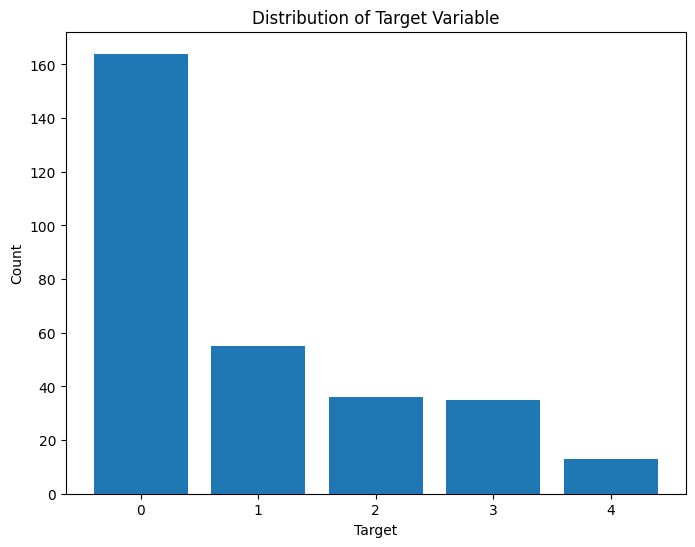

In [ ]:
# Draw a bar graph for the 'target' column
target_counts = heart_df['target'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.xticks(target_counts.index)
plt.show()

In [4]:
initial_rows = len(heart_df)
heart_df.dropna(inplace=True)
remaining_rows = len(heart_df)

print(f"Number of rows before dropping NaNs: {initial_rows}")
print(f"Number of rows after dropping NaNs: {remaining_rows}")

Number of rows before dropping NaNs: 303
Number of rows after dropping NaNs: 297


In [5]:
# Replace target 0 with False and others with True
heart_df['target'] = heart_df['target'] != 0

# Display value counts of the modified target column
display(heart_df['target'].value_counts())

,count
target,
False,160
True,137


**Data Preparation**

In [25]:
# Separate features (X) and label (y)
X = heart_df.drop('target', axis=1)
y = heart_df['target']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for compatibility
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for compatibility

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) # Test set without batching

print("Data preparation complete. Training and test DataLoaders created.")

Data preparation complete. Training and test DataLoaders created.


**Define Model**

In [23]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Determine the input dimension based on the training data
input_dim = X_train_tensor.shape[1]

print("PyTorch model defined.")

PyTorch model defined.


**Train Model**

In [29]:
def train_model(input_dim, train_loader, test_loader, criterion, optimizer_class, epochs, learning_rate):
    """Trains the PyTorch model and returns the trained model, training loss history, training accuracy history, and test accuracy history.

    Args:
        input_dim: The input dimension of the model.
        train_loader: The DataLoader for the training data.
        test_loader: The DataLoader for the test data.
        criterion: The loss function.
        optimizer_class: The optimizer class.
        epochs: The number of training epochs.
        learning_rate: The learning rate for the optimizer.

    Returns:
        model: The trained PyTorch model.
        train_loss_history: A list containing the training loss for each epoch.
        train_accuracy_history: A list containing the training accuracy for each epoch.
        test_accuracy_history: A list containing the test accuracy for each epoch.
    """
    model = HeartDiseaseModel(input_dim)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    train_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predicted = (outputs > 0.5).float()
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)


        epoch_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct_train_predictions / total_train_predictions
        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_train_accuracy)

        # Evaluate on test set
        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                correct_test_predictions = (predicted == labels).sum().item()
                total_test_predictions = labels.size(0)
                epoch_test_accuracy = correct_test_predictions / total_test_predictions
                test_accuracy_history.append(epoch_test_accuracy)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")


    print("Training finished.")
    return model, train_loss_history, train_accuracy_history, test_accuracy_history

In [32]:
# Define the loss function and optimizer class
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimizer_class = SGD
learning_rate = 0.01

# Set the number of epochs
epochs = 2000

# Train the model and get the training loss and accuracy history
model, train_loss_history, train_accuracy_history, test_accuracy_history = train_model(input_dim, train_loader, test_loader, criterion, optimizer_class, epochs, learning_rate)

Epoch 1, Loss: 0.8201, Train Accuracy: 0.5949, Test Accuracy: 0.6000
Epoch 2, Loss: 0.7098, Train Accuracy: 0.5063, Test Accuracy: 0.4667
Epoch 3, Loss: 0.6675, Train Accuracy: 0.5907, Test Accuracy: 0.4833
Epoch 4, Loss: 0.6745, Train Accuracy: 0.6034, Test Accuracy: 0.4667
Epoch 5, Loss: 0.6697, Train Accuracy: 0.5781, Test Accuracy: 0.6000
Epoch 6, Loss: 0.6713, Train Accuracy: 0.5654, Test Accuracy: 0.5833
Epoch 7, Loss: 0.6601, Train Accuracy: 0.6034, Test Accuracy: 0.5833
Epoch 8, Loss: 0.6407, Train Accuracy: 0.6118, Test Accuracy: 0.4667
Epoch 9, Loss: 0.6920, Train Accuracy: 0.5781, Test Accuracy: 0.4833
Epoch 10, Loss: 0.6406, Train Accuracy: 0.6414, Test Accuracy: 0.6333
Epoch 11, Loss: 0.6357, Train Accuracy: 0.6835, Test Accuracy: 0.6167
Epoch 12, Loss: 0.6273, Train Accuracy: 0.6582, Test Accuracy: 0.5667
Epoch 13, Loss: 0.6467, Train Accuracy: 0.6414, Test Accuracy: 0.6000
Epoch 14, Loss: 0.6534, Train Accuracy: 0.6456, Test Accuracy: 0.6833
Epoch 15, Loss: 0.6329, Train

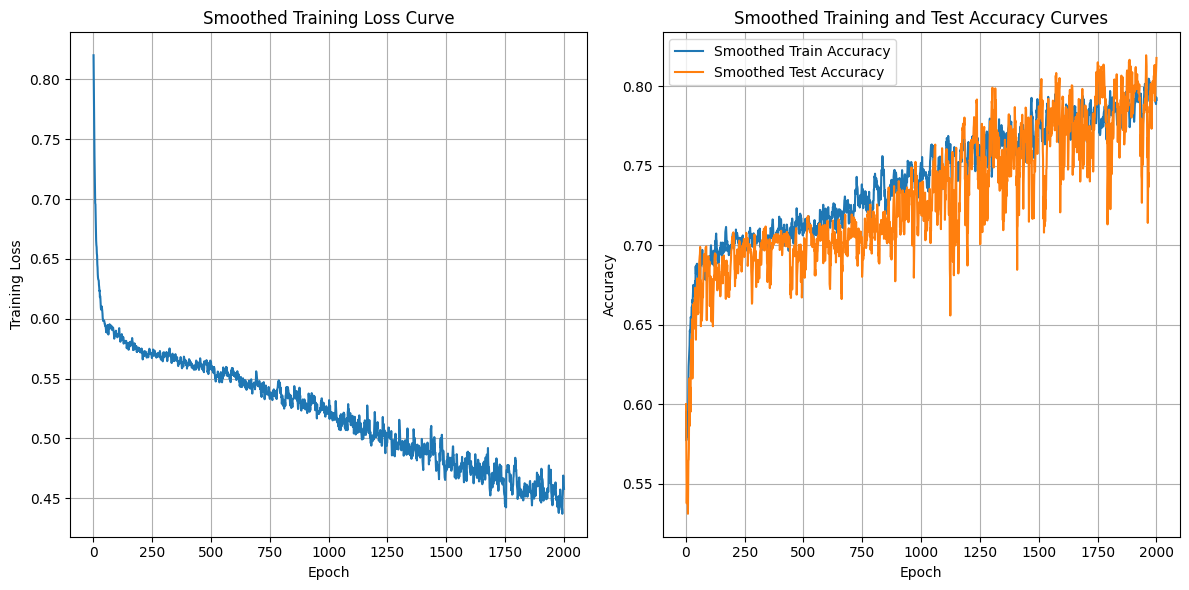

In [33]:
# Function to apply a rolling average for smoothing
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing to the histories
smoothed_train_loss = smooth_curve(train_loss_history)
smoothed_train_accuracy = smooth_curve(train_accuracy_history)
smoothed_test_accuracy = smooth_curve(test_accuracy_history)

# Plot the training loss and accuracy curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), smoothed_train_loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Smoothed Training Loss Curve")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), smoothed_train_accuracy, label='Smoothed Train Accuracy')
plt.plot(range(1, epochs + 1), smoothed_test_accuracy, label='Smoothed Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Smoothed Training and Test Accuracy Curves")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()